# Character level language model - Dinosaurus Island
Welcome to Dinosaurus Island! 65 million years ago, dinosaurs existed, and in this assignment, they have returned.

You are in charge of a special task: Leading biology researchers are creating new breeds of dinosaurs and bringing them to life on earth, and your job is to give names to these dinosaurs. If a dinosaur does not like its name, it might go berserk, so choose wisely!

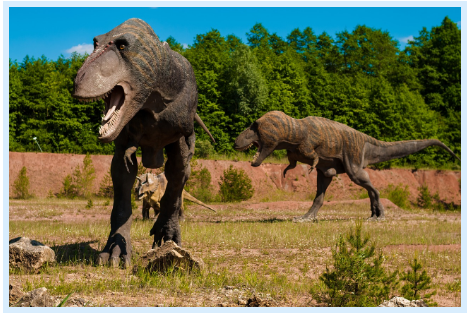

Luckily you're equipped with some deep learning now, and you will use it to save the day! Your assistant has collected a list of all the dinosaur names they could find, and compiled them into this [dataset](dinos.txt). (Feel free to take a look by clicking the previous link.) To create new dinosaur names, you will build a character-level language model to generate new names. Your algorithm will learn the different name patterns, and randomly generate new names. Hopefully this algorithm will keep you and your team safe from the dinosaurs' wrath! 

By the time you complete this assignment, you'll be able to:

* Store text data for processing using an RNN 
* Build a character-level text generation model using an RNN
* Sample novel sequences in an RNN
* Explain the vanishing/exploding gradient problem in RNNs
* Apply gradient clipping as a solution for exploding gradients

Begin by loading in some functions that are provided for you in `rnn_utils`. Specifically, you have access to functions such as `rnn_forward` and `rnn_backward` which are equivalent to those you've implemented in the previous assignment. 

## Table of Contents

- [Packages](#0)
- [1 - Problem Statement](#1)
    - [1.1 - Dataset and Preprocessing](#1-1)
    - [1.2 - Overview of the Model](#1-2)
- [2 - Building Blocks of the Model](#2)
    - [2.1 - Clipping the Gradients in the Optimization Loop](#2-1)
        - [Exercise 1 - clip](#ex-1)
    - [2.2 - Sampling](#2-2)
        - [Exercise 2 - sample](#ex-2)
- [3 - Building the Language Model](#3)
    - [3.1 - Gradient Descent](#3-1)
        - [Exercise 3 - optimize](#ex-3)
    - [3.2 - Training the Model](#3-2)
        - [Exercise 4 - model](#ex-4)
- [4 - Writing like Shakespeare (OPTIONAL/UNGRADED)](#4)
- [5 - References](#5)

<a name='0'></a>
## Packages

In [ ]:
import numpy as np
from utils import *
import random
import pprint
import copy

<a name='1'></a>
## 1 - Problem Statement

<a name='1-1'></a>
### 1.1 - Dataset and Preprocessing

Run the following cell to read the dataset of dinosaur names, create a list of unique characters (such as a-z), and compute the dataset and vocabulary size. 

In [ ]:
data = open('dinos.txt', 'r').read()
data= data.lower()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))

There are 19909 total characters and 27 unique characters in your data.



* The characters are a-z (26 characters) plus the "\n" (or newline character).
* In this assignment, the newline character "\n" plays a role similar to the `<EOS>` (or "End of sentence") token discussed in lecture.  
    - Here, "\n" indicates the end of the dinosaur name rather than the end of a sentence. 
* `char_to_ix`: In the cell below, you'll create a Python dictionary (i.e., a hash table) to map each character to an index from 0-26.
* `ix_to_char`: Then, you'll create a second Python dictionary that maps each index back to the corresponding character. 
    -  This will help you figure out which index corresponds to which character in the probability distribution output of the softmax layer. 

In [ ]:
chars = sorted(chars)
print(chars)

['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(ix_to_char)

{   0: '\n',
    1: 'a',
    2: 'b',
    3: 'c',
    4: 'd',
    5: 'e',
    6: 'f',
    7: 'g',
    8: 'h',
    9: 'i',
    10: 'j',
    11: 'k',
    12: 'l',
    13: 'm',
    14: 'n',
    15: 'o',
    16: 'p',
    17: 'q',
    18: 'r',
    19: 's',
    20: 't',
    21: 'u',
    22: 'v',
    23: 'w',
    24: 'x',
    25: 'y',
    26: 'z'}


<a name='1-2'></a>
### 1.2 - Overview of the Model

Your model will have the following structure: 

- Initialize parameters 
- Run the optimization loop
    - Forward propagation to compute the loss function
    - Backward propagation to compute the gradients with respect to the loss function
    - Clip the gradients to avoid exploding gradients
    - Using the gradients, update your parameters with the gradient descent update rule.
- Return the learned parameters 

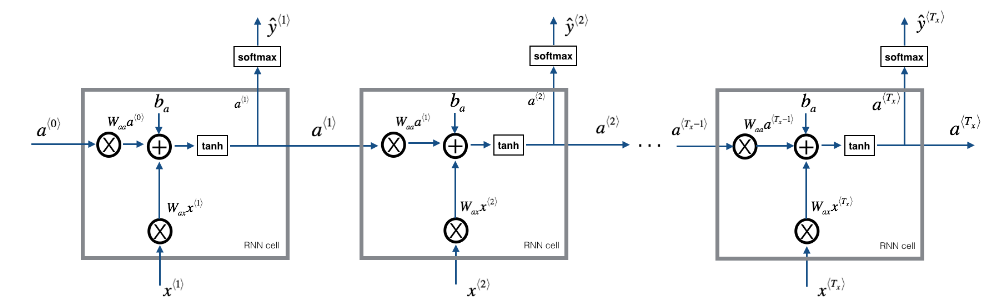

<b>Figure 1</b>: Recurrent Neural Network, similar to what you built in the previous notebook "Building a Recurrent Neural Network - Step by Step."  </center></caption>

* At each time-step, the RNN tries to predict what the next character is, given the previous characters. 
* $\mathbf{X} = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$ is a list of characters from the training set.
* $\mathbf{Y} = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$ is the same list of characters but shifted one character forward. 
* At every time-step $t$, $y^{\langle t \rangle} = x^{\langle t+1 \rangle}$.  The prediction at time $t$ is the same as the input at time $t + 1$.

<a name='2'></a>
## 2 - Building Blocks of the Model

In this part, you will build two important blocks of the overall model:

1. Gradient clipping: to avoid exploding gradients
2. Sampling: a technique used to generate characters

You will then apply these two functions to build the model.

<a name='2-1'></a>
### 2.1 - Clipping the Gradients in the Optimization Loop

In this section you will implement the `clip` function that you will call inside of your optimization loop. 

#### Exploding gradients
* When gradients are very large, they're called "exploding gradients."  
* Exploding gradients make the training process more difficult, because the updates may be so large that they "overshoot" the optimal values during back propagation.

Recall that your overall loop structure usually consists of:
* forward pass, 
* cost computation, 
* backward pass, 
* parameter update. 

Before updating the parameters, you will perform gradient clipping to make sure that your gradients are not "exploding."

#### Gradient clipping
In the exercise below, you will implement a function `clip` that takes in a dictionary of gradients and returns a clipped version of gradients, if needed. 

* There are different ways to clip gradients.
* You will use a simple element-wise clipping procedure, in which every element of the gradient vector is clipped to fall between some range [-N, N]. 
* For example, if the N=10
    - The range is [-10, 10]
    - If any component of the gradient vector is greater than 10, it is set to 10.
    - If any component of the gradient vector is less than -10, it is set to -10. 
    - If any components are between -10 and 10, they keep their original values.

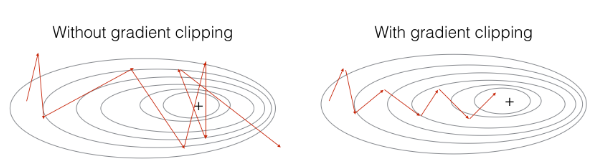
Figure 2</b>: Visualization of gradient descent with and without gradient clipping, in a case where the network is running into "exploding gradient" problems. </center></caption>

<a name='ex-1'></a>
### Exercise 1 - clip
    
Return the clipped gradients of your dictionary `gradients`. 
    
* Your function takes in a maximum threshold and returns the clipped versions of the gradients. 
* You can check out [numpy.clip](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.clip.html) for more info. 
    - You will need to use the argument "`out = ...`".
    - Using the "`out`" parameter allows you to update a variable "in-place".
    - If you don't use "`out`" argument, the clipped variable is stored in the variable "gradient" but does not update the gradient variables `dWax`, `dWaa`, `dWya`, `db`, `dby`.

In [ ]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
### GRADED FUNCTION: clip

def clip(gradients, maxValue):
    '''
    Clips the gradients' values between minimum and maximum.
    
    Arguments:
    gradients -- a dictionary containing the gradients "dWaa", "dWax", "dWya", "db", "dby"
    maxValue -- everything above this number is set to this number, and everything less than -maxValue is set to -maxValue
    
    Returns: 
    gradients -- a dictionary with the clipped gradients.
    '''
    gradients = copy.deepcopy(gradients)
    
    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['db'], gradients['dby']
   
    ### START CODE HERE ###
    # Clip to mitigate exploding gradients, loop over [dWax, dWaa, dWya, db, dby]. (≈2 lines)
    for gradient in dWaa, dWax, dWya, db, dby:
        np.clip(gradient, -(maxValue), maxValue, out = gradient)
    ### END CODE HERE ###
    
    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}
    
    return gradients

In [ ]:
# Test with a max value of 10
def clip_test(target, mValue):
    print(f"\nGradients for mValue={mValue}")
    np.random.seed(3)
    dWax = np.random.randn(5, 3) * 10
    dWaa = np.random.randn(5, 5) * 10
    dWya = np.random.randn(2, 5) * 10
    db = np.random.randn(5, 1) * 10
    dby = np.random.randn(2, 1) * 10
    gradients = {"dWax": dWax, "dWaa": dWaa, "dWya": dWya, "db": db, "dby": dby}

    gradients2 = target(gradients, mValue)
    print("gradients[\"dWaa\"][1][2] =", gradients2["dWaa"][1][2])
    print("gradients[\"dWax\"][3][1] =", gradients2["dWax"][3][1])
    print("gradients[\"dWya\"][1][2] =", gradients2["dWya"][1][2])
    print("gradients[\"db\"][4] =", gradients2["db"][4])
    print("gradients[\"dby\"][1] =", gradients2["dby"][1])
    
    for grad in gradients2.keys():
        valuei = gradients[grad]
        valuef = gradients2[grad]
        mink = np.min(valuef)
        maxk = np.max(valuef)
        assert mink >= -abs(mValue), f"Problem with {grad}. Set a_min to -mValue in the np.clip call"
        assert maxk <= abs(mValue), f"Problem with {grad}.Set a_max to mValue in the np.clip call"
        index_not_clipped = np.logical_and(valuei <= mValue, valuei >= -mValue)
        assert np.all(valuei[index_not_clipped] == valuef[index_not_clipped]), f" Problem with {grad}. Some values that should not have changed, changed during the clipping process."
    
    print("\033[92mAll tests passed!\x1b[0m")
    
clip_test(clip, 10)
clip_test(clip, 5)


Gradients for mValue=10
gradients["dWaa"][1][2] = 10.0
gradients["dWax"][3][1] = -10.0
gradients["dWya"][1][2] = 0.2971381536101662
gradients["db"][4] = [10.]
gradients["dby"][1] = [8.45833407]
All tests passed!

Gradients for mValue=5
gradients["dWaa"][1][2] = 5.0
gradients["dWax"][3][1] = -5.0
gradients["dWya"][1][2] = 0.2971381536101662
gradients["db"][4] = [5.]
gradients["dby"][1] = [5.]
All tests passed!


<a name='2-2'></a>
### 2.2 - Sampling

Now, assume that your model is trained, and you would like to generate new text (characters). The process of generation is explained in the picture below:

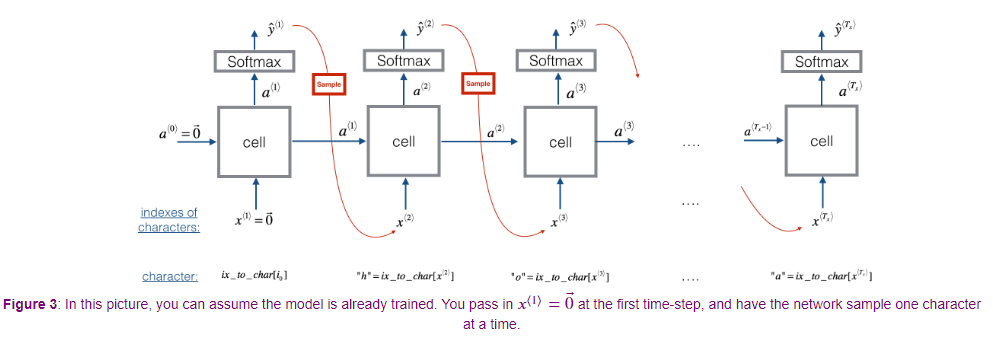

<a name='ex-2'></a>
### Exercise 2 - sample

Implement the `sample` function below to sample characters. 

You need to carry out 4 steps:

- **Step 1**: Input the "dummy" vector of zeros $x^{\langle 1 \rangle} = \vec{0}$. 
    - This is the default input before you've generated any characters. 
    You also set $a^{\langle 0 \rangle} = \vec{0}$

- **Step 2**: Run one step of forward propagation to get $a^{\langle 1 \rangle}$ and $\hat{y}^{\langle 1 \rangle}$. Here are the equations:
​
*hidden state:*  
$$ a^{\langle t+1 \rangle} = \tanh(W_{ax}  x^{\langle t+1 \rangle } + W_{aa} a^{\langle t \rangle } + b)\tag{1}$$
​
*activation:*
$$ z^{\langle t + 1 \rangle } = W_{ya}  a^{\langle t + 1 \rangle } + b_y \tag{2}$$
​
*prediction:*
$$ \hat{y}^{\langle t+1 \rangle } = softmax(z^{\langle t + 1 \rangle })\tag{3}$$
​
- Details about $\hat{y}^{\langle t+1 \rangle }$:
   - Note that $\hat{y}^{\langle t+1 \rangle }$ is a (softmax) probability vector (its entries are between 0 and 1 and sum to 1). 
   - $\hat{y}^{\langle t+1 \rangle}_i$ represents the probability that the character indexed by "i" is the next character.  
   - A `softmax()` function is provided for you to use.

##### Additional Hints

- $x^{\langle 1 \rangle}$ is `x` in the code. When creating the one-hot vector, make a numpy array of zeros, with the number of rows equal to the number of unique characters, and the number of columns equal to one.  It's a 2D and not a 1D array.
- $a^{\langle 0 \rangle}$ is `a_prev` in the code.  It is a numpy array of zeros, where the number of rows is $n_{a}$, and number of columns is 1.  It is a 2D array as well.  $n_{a}$ is retrieved by getting the number of columns in $W_{aa}$ (the numbers need to match in order for the matrix multiplication $W_{aa}a^{\langle t \rangle}$ to work.
- Official documentation for [numpy.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) and [numpy.tanh](https://docs.scipy.org/doc/numpy/reference/generated/numpy.tanh.html)

In [ ]:
matrix1 = np.array([[1,1],[2,2],[3,3]]) # (3,2)
matrix2 = np.array([[0],[0],[0]]) # (3,1) 
vector1D = np.array([1,1]) # (2,) 
vector2D = np.array([[1],[1]]) # (2,1)
print("matrix1 \n", matrix1,"\n")
print("matrix2 \n", matrix2,"\n")
print("vector1D \n", vector1D,"\n")
print("vector2D \n", vector2D)

matrix1 
 [[1 1]
 [2 2]
 [3 3]] 

matrix2 
 [[0]
 [0]
 [0]] 

vector1D 
 [1 1] 

vector2D 
 [[1]
 [1]]


In [ ]:
print("Multiply 2D and 1D arrays: result is a 1D array\n", 
      np.dot(matrix1,vector1D))
print("Multiply 2D and 2D arrays: result is a 2D array\n", 
      np.dot(matrix1,vector2D))

Multiply 2D and 1D arrays: result is a 1D array
 [2 4 6]
Multiply 2D and 2D arrays: result is a 2D array
 [[2]
 [4]
 [6]]


In [ ]:
print("Adding (3 x 1) vector to a (3 x 1) vector is a (3 x 1) vector\n",
      "This is what we want here!\n", 
      np.dot(matrix1,vector2D) + matrix2)

Adding (3 x 1) vector to a (3 x 1) vector is a (3 x 1) vector
 This is what we want here!
 [[2]
 [4]
 [6]]


In [ ]:
print("Adding a (3,) vector to a (3 x 1) vector\n",
      "broadcasts the 1D array across the second dimension\n",
      "Not what we want here!\n",
      np.dot(matrix1,vector1D) + matrix2
     )

Adding a (3,) vector to a (3 x 1) vector
 broadcasts the 1D array across the second dimension
 Not what we want here!
 [[2 4 6]
 [2 4 6]
 [2 4 6]]


- **Step 3**: Sampling: 
    - Now that you have $y^{\langle t+1 \rangle}$, you want to select the next letter in the dinosaur name. If you select the most probable, the model will always generate the same result given a starting letter. To make the results more interesting, use `np.random.choice` to select a next letter that is *likely*, but not always the same.
    - Pick the next character's **index** according to the probability distribution specified by $\hat{y}^{\langle t+1 \rangle }$. 
    - This means that if $\hat{y}^{\langle t+1 \rangle }_i = 0.16$, you will pick the index "i" with 16% probability. 
    - Use [np.random.choice](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.choice.html).

    Example of how to use `np.random.choice()`:
    ```python
    np.random.seed(0)
    probs = np.array([0.1, 0.0, 0.7, 0.2])
    idx = np.random.choice(range(len(probs), p = probs)
    ```
    
    - This means that you will pick the index (`idx`) according to the distribution: 

    $P(index = 0) = 0.1, P(index = 1) = 0.0, P(index = 2) = 0.7, P(index = 3) = 0.2$.

    - Note that the value that's set to `p` should be set to a 1D vector.
    - Also notice that $\hat{y}^{\langle t+1 \rangle}$, which is `y` in the code, is a 2D array.
    - Also notice, while in your implementation, the first argument to `np.random.choice` is just an ordered list [0,1,.., vocab_len-1], it is *not* appropriate to use `char_to_ix.values()`. The *order* of values returned by a Python dictionary `.values()` call will be the same order as they are added to the dictionary. The grader may have a different order when it runs your routine than when you run it in your notebook.

##### Additional Hints
- Documentation for the built-in Python function [range](https://docs.python.org/3/library/functions.html#func-range)
- Docs for [numpy.ravel](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html), which takes a multi-dimensional array and returns its contents inside of a 1D vector.
```Python
arr = np.array([[1,2],[3,4]])
print("arr")
print(arr)
print("arr.ravel()")
print(arr.ravel())
```
Output:
```Python
arr
[[1 2]
 [3 4]]
arr.ravel()
[1 2 3 4]
```

- Note that `append` is an "in-place" operation, which means the changes made by the method will remain after the call completes.  In other words, don't do this:

```Python
fun_hobbies = fun_hobbies.append('learning')  ## Doesn't give you what you want!
```

- **Step 4**: Update to $x^{\langle t \rangle }$ 
    - The last step to implement in `sample()` is to update the variable `x`, which currently stores $x^{\langle t \rangle }$, with the value of $x^{\langle t + 1 \rangle }$. 
    - You will represent $x^{\langle t + 1 \rangle }$ by creating a one-hot vector corresponding to the character that you have chosen as your prediction. 
    - You will then forward propagate $x^{\langle t + 1 \rangle }$ in Step 1 and keep repeating the process until you get a `"\n"` character, indicating that you have reached the end of the dinosaur name. 

##### Additional Hints
- In order to reset `x` before setting it to the new one-hot vector, you'll want to set all the values to zero.
    - You can either create a new numpy array: [numpy.zeros](https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html)
    - Or fill all values with a single number: [numpy.ndarray.fill](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.fill.html)

In [ ]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: sample

def sample(parameters, char_to_ix, seed):
    """
    Sample a sequence of characters according to a sequence of probability distributions output of the RNN

    Arguments:
    parameters -- Python dictionary containing the parameters Waa, Wax, Wya, by, and b. 
    char_to_ix -- Python dictionary mapping each character to an index.
    seed -- Used for grading purposes. Do not worry about it.

    Returns:
    indices -- A list of length n containing the indices of the sampled characters.
    """
    
    # Retrieve parameters and relevant shapes from "parameters" dictionary
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    vocab_size = by.shape[0]
    n_a = Waa.shape[1]
    
    ### START CODE HERE ###
    # Step 1: Create the a zero vector x that can be used as the one-hot vector 
    # Representing the first character (initializing the sequence generation). (≈1 line)
    x = np.zeros((vocab_size,1))
    # Step 1': Initialize a_prev as zeros (≈1 line)
    a_prev = np.zeros((n_a,1))
    
    # Create an empty list of indices. This is the list which will contain the list of indices of the characters to generate (≈1 line)
    indices = []
    
    # idx is the index of the one-hot vector x that is set to 1
    # All other positions in x are zero.
    # Initialize idx to -1
    idx = -1
    
    # Loop over time-steps t. At each time-step:
    # Sample a character from a probability distribution 
    # And append its index (`idx`) to the list "indices". 
    # You'll stop if you reach 50 characters 
    # (which should be very unlikely with a well-trained model).
    # Setting the maximum number of characters helps with debugging and prevents infinite loops. 
    counter = 0
    newline_character = char_to_ix['\n']
    
    while (idx != newline_character and counter != 50):
        
        # Step 2: Forward propagate x using the equations (1), (2) and (3)
        a = np.tanh(np.dot(Wax,x)+np.dot(Waa,a_prev)+b)
        z = np.dot(Wya,a)+by
        y = softmax(z)
        
        # For grading purposes
        np.random.seed(counter + seed) 
        
        # Step 3: Sample the index of a character within the vocabulary from the probability distribution y
        # (see additional hints above)
        idx = np.random.choice(list(range(vocab_size)), p = y.ravel())
        # Append the index to "indices"
        indices.append(idx)
        
        # Step 4: Overwrite the input x with one that corresponds to the sampled index `idx`.
        # (see additional hints above)
        x = np.zeros((vocab_size,1))
        x[idx] = 1
        
        # Update "a_prev" to be "a"
        a_prev = a
        
        # for grading purposes
        seed += 1
        counter +=1
        
    ### END CODE HERE ###

    if (counter == 50):
        indices.append(char_to_ix['\n'])
    
    return indices

In [ ]:
def sample_test(target):
    np.random.seed(24)
    _, n_a = 20, 100
    Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
    b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
    parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}


    indices = target(parameters, char_to_ix, 0)
    print("Sampling:")
    print("list of sampled indices:\n", indices)
    print("list of sampled characters:\n", [ix_to_char[i] for i in indices])
    
    assert len(indices) < 52, "Indices lenght must be smaller than 52"
    assert indices[-1] == char_to_ix['\n'], "All samples must end with \\n"
    assert min(indices) >= 0 and max(indices) < len(char_to_ix), f"Sampled indexes must be between 0 and len(char_to_ix)={len(char_to_ix)}"
    assert np.allclose(indices[0:6], [23, 16, 26, 26, 24, 3]), "Wrong values"
    
    print("\033[92mAll tests passed!")

sample_test(sample)

Sampling:
list of sampled indices:
 [23, 16, 26, 26, 24, 3, 21, 1, 7, 24, 15, 3, 25, 20, 6, 13, 10, 8, 20, 12, 2, 0]
list of sampled characters:
 ['w', 'p', 'z', 'z', 'x', 'c', 'u', 'a', 'g', 'x', 'o', 'c', 'y', 't', 'f', 'm', 'j', 'h', 't', 'l', 'b', '\n']
All tests passed!


<font color='blue'><b>What you should remember</b>: 
* Very large, or "exploding" gradients updates can be so large that they "overshoot" the optimal values during back prop -- making training difficult 
    * Clip gradients before updating the parameters to avoid exploding gradients 
* Sampling is a technique you can use to pick the index of the next character according to a probability distribution.
    * To begin character-level sampling: 
        * Input a "dummy" vector of zeros as a default input 
        * Run one step of forward propagation to get 𝑎⟨1⟩ (your first character) and 𝑦̂ ⟨1⟩ (probability distribution for the following character) 
        * When sampling, avoid generating the same result each time given the starting letter (and make your names more interesting!) by using `np.random.choice`

<a name='3'></a>
## 3 - Building the Language Model 

It's time to build the character-level language model for text generation! 


<a name='3-1'></a>
### 3.1 - Gradient Descent 

In this section you will implement a function performing one step of stochastic gradient descent (with clipped gradients). You'll go through the training examples one at a time, so the optimization algorithm will be stochastic gradient descent. 

As a reminder, here are the steps of a common optimization loop for an RNN:

- Forward propagate through the RNN to compute the loss
- Backward propagate through time to compute the gradients of the loss with respect to the parameters
- Clip the gradients
- Update the parameters using gradient descent 

<a name='ex-3'></a>
### Exercise 3 - optimize

Implement the optimization process (one step of stochastic gradient descent).

The following functions are provided:

```python
def rnn_forward(X, Y, a_prev, parameters):
    """ Performs the forward propagation through the RNN and computes the cross-entropy loss.
    It returns the loss' value as well as a "cache" storing values to be used in backpropagation."""
    ....
    return loss, cache
    
def rnn_backward(X, Y, parameters, cache):
    """ Performs the backward propagation through time to compute the gradients of the loss with respect
    to the parameters. It returns also all the hidden states."""
    ...
    return gradients, a

def update_parameters(parameters, gradients, learning_rate):
    """ Updates parameters using the Gradient Descent Update Rule."""
    ...
    return parameters
```

Recall that you previously implemented the `clip` function:

#### Parameters

* Note that the weights and biases inside the `parameters` dictionary are being updated by the optimization, even though `parameters` is not one of the returned values of the `optimize` function. The `parameters` dictionary is passed by reference into the function, so changes to this dictionary are making changes to the `parameters` dictionary even when accessed outside of the function.
* Python dictionaries and lists are "pass by reference", which means that if you pass a dictionary into a function and modify the dictionary within the function, this changes that same dictionary (it's not a copy of the dictionary).

In [ ]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: optimize

def optimize(X, Y, a_prev, parameters, learning_rate = 0.01):
    """
    Execute one step of the optimization to train the model.
    
    Arguments:
    X -- list of integers, where each integer is a number that maps to a character in the vocabulary.
    Y -- list of integers, exactly the same as X but shifted one index to the left.
    a_prev -- previous hidden state.
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    learning_rate -- learning rate for the model.
    
    Returns:
    loss -- value of the loss function (cross-entropy)
    gradients -- python dictionary containing:
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dWya -- Gradients of hidden-to-output weights, of shape (n_y, n_a)
                        db -- Gradients of bias vector, of shape (n_a, 1)
                        dby -- Gradients of output bias vector, of shape (n_y, 1)
    a[len(X)-1] -- the last hidden state, of shape (n_a, 1)
    """
    
    ### START CODE HERE ###
    
    # Forward propagate through time (≈1 line)
    loss, cache = rnn_forward(X, Y, a_prev, parameters)   
    # Backpropagate through time (≈1 line)
    gradients, a = rnn_backward(X, Y, parameters, cache)
    
    # Clip your gradients between -5 (min) and 5 (max) (≈1 line)
    gradients = clip(gradients,5)
    
    # Update parameters (≈1 line)
    parameters = update_parameters(parameters, gradients, learning_rate)
    
    ### END CODE HERE ###
    
    return loss, gradients, a[len(X)-1]

In [ ]:
def optimize_test(target):
    np.random.seed(1)
    vocab_size, n_a = 27, 100
    a_prev = np.random.randn(n_a, 1)
    Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
    b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
    parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}
    X = [12, 3, 5, 11, 22, 3]
    Y = [4, 14, 11, 22, 25, 26]
    old_parameters = copy.deepcopy(parameters)
    loss, gradients, a_last = target(X, Y, a_prev, parameters, learning_rate = 0.01)
    print("Loss =", loss)
    print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
    print("np.argmax(gradients[\"dWax\"]) =", np.argmax(gradients["dWax"]))
    print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
    print("gradients[\"db\"][4] =", gradients["db"][4])
    print("gradients[\"dby\"][1] =", gradients["dby"][1])
    print("a_last[4] =", a_last[4])
    
    assert np.isclose(loss, 126.5039757), "Problems with the call of the rnn_forward function"
    for grad in gradients.values():
        assert np.min(grad) >= -5, "Problems in the clip function call"
        assert np.max(grad) <= 5, "Problems in the clip function call"
    assert np.allclose(gradients['dWaa'][1, 2], 0.1947093), "Unexpected gradients. Check the rnn_backward call"
    assert np.allclose(gradients['dWya'][1, 2], -0.007773876), "Unexpected gradients. Check the rnn_backward call"
    assert not np.allclose(parameters['Wya'], old_parameters['Wya']), "parameters were not updated"
    
    print("\033[92mAll tests passed!")

optimize_test(optimize)

Loss = 126.50397572165369
gradients["dWaa"][1][2] = 0.19470931534720926
np.argmax(gradients["dWax"]) = 93
gradients["dWya"][1][2] = -0.007773876032003706
gradients["db"][4] = [-0.06809825]
gradients["dby"][1] = [0.01538192]
a_last[4] = [-1.]
All tests passed!


<a name='3-2'></a>
### 3.2 - Training the Model 

* Given the dataset of dinosaur names, you'll use each line of the dataset (one name) as one training example. 
* Every 2000 steps of stochastic gradient descent, you will sample several randomly chosen names to see how the algorithm is doing. 
 
<a name='ex-4'></a>
### Exercise 4 - model

Implement `model()`. 

When `examples[index]` contains one dinosaur name (string), to create an example (X, Y), you can use this:

##### Set the index `idx` into the list of examples

* Using the for-loop, walk through the shuffled list of dinosaur names in the list "examples."
* For example, if there are n_e examples, and the for-loop increments the index to n_e onwards, think of how you would make the index cycle back to 0, so that you can continue feeding the examples into the model when j is n_e, n_e + 1, etc.
* Hint: n_e + 1 divided by n_e is zero with a remainder of 1.
* `%` is the modulo operator in python.

##### Extract a single example from the list of examples
* `single_example`: use the `idx` index that you set previously to get one word from the list of examples.

##### Convert a string into a list of characters: `single_example_chars`
* `single_example_chars`: A string is a list of characters.
* You can use a list comprehension (recommended over for-loops) to generate a list of characters.
```Python
str = 'I love learning'
list_of_chars = [c for c in str]
print(list_of_chars)
```

```
['I', ' ', 'l', 'o', 'v', 'e', ' ', 'l', 'e', 'a', 'r', 'n', 'i', 'n', 'g']
```

* For more on [list comprehensions](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions):

##### Convert list of characters to a list of integers: `single_example_ix`
* Create a list that contains the index numbers associated with each character.
* Use the dictionary `char_to_ix`
* You can combine this with the list comprehension that is used to get a list of characters from a string.

##### Create the list of input characters: `X`
* `rnn_forward` uses the **`None`** value as a flag to set the input vector as a zero-vector.
* Prepend the list [**`None`**] in front of the list of input characters.
* There is more than one way to prepend a value to a list.  One way is to add two lists together: `['a'] + ['b']`

##### Get the integer representation of the newline character `ix_newline`
* `ix_newline`: The newline character signals the end of the dinosaur name.
    - Get the integer representation of the newline character `'\n'`.
    - Use `char_to_ix`

##### Set the list of labels (integer representation of the characters): `Y`
* The goal is to train the RNN to predict the next letter in the name, so the labels are the list of characters that are one time-step ahead of the characters in the input `X`.
    - For example, `Y[0]` contains the same value as `X[1]`  
* The RNN should predict a newline at the last letter, so add `ix_newline` to the end of the labels. 
    - Append the integer representation of the newline character to the end of `Y`.
    - Note that `append` is an in-place operation.
    - It might be easier for you to add two lists together.

In [ ]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: model

def model(data_x, ix_to_char, char_to_ix, num_iterations = 35000, n_a = 50, dino_names = 7, vocab_size = 27, verbose = False):
    """
    Trains the model and generates dinosaur names. 
    
    Arguments:
    data_x -- text corpus, divided in words
    ix_to_char -- dictionary that maps the index to a character
    char_to_ix -- dictionary that maps a character to an index
    num_iterations -- number of iterations to train the model for
    n_a -- number of units of the RNN cell
    dino_names -- number of dinosaur names you want to sample at each iteration. 
    vocab_size -- number of unique characters found in the text (size of the vocabulary)
    
    Returns:
    parameters -- learned parameters
    """
    
    # Retrieve n_x and n_y from vocab_size
    n_x, n_y = vocab_size, vocab_size
    
    # Initialize parameters
    parameters = initialize_parameters(n_a, n_x, n_y)
    
    # Initialize loss (this is required because we want to smooth our loss)
    loss = get_initial_loss(vocab_size, dino_names)
    
    # Build list of all dinosaur names (training examples).
    examples = [x.strip() for x in data_x]
    
    # Shuffle list of all dinosaur names
    np.random.seed(0)
    np.random.shuffle(examples)
    
    # Initialize the hidden state of your LSTM
    a_prev = np.zeros((n_a, 1))
    
    # for grading purposes
    last_dino_name = "abc"
    
    # Optimization loop
    for j in range(num_iterations):
        
        ### START CODE HERE ###
        
        # Set the index `idx` (see instructions above)
        idx = j % len(examples)
        
        # Set the input X (see instructions above)
        single_example = [None]
        single_example_chars = char_to_ix
        single_example_ix = idx
        X = single_example + [single_example_chars[ch] for ch in examples[single_example_ix]] 
        
        # Set the labels Y (see instructions above)
        ix_newline = single_example_chars["\n"]
        Y = X[1:]+[ix_newline]

        # Perform one optimization step: Forward-prop -> Backward-prop -> Clip -> Update parameters
        # Choose a learning rate of 0.01
        curr_loss, gradients, a_prev = optimize(X, Y, a_prev, parameters, learning_rate = 0.01)
         
        
        ### END CODE HERE ###
        
        # debug statements to aid in correctly forming X, Y
        if verbose and j in [0, len(examples) -1, len(examples)]:
            print("j = " , j, "idx = ", idx,) 
        if verbose and j in [0]:
            print("single_example =", single_example)
            print("single_example_chars", single_example_chars)
            print("single_example_ix", single_example_ix)
            print(" X = ", X, "\n", "Y =       ", Y, "\n")
        
        # Use a latency trick to keep the loss smooth. It happens here to accelerate the training.
        loss = smooth(loss, curr_loss)

        # Every 2000 Iteration, generate "n" characters thanks to sample() to check if the model is learning properly
        if j % 2000 == 0:
            
            print('Iteration: %d, Loss: %f' % (j, loss) + '\n')
            
            # The number of dinosaur names to print
            seed = 0
            for name in range(dino_names):
                
                # Sample indices and print them
                sampled_indices = sample(parameters, char_to_ix, seed)
                last_dino_name = get_sample(sampled_indices, ix_to_char)
                print(last_dino_name.replace('\n', ''))
                
                seed += 1  # To get the same result (for grading purposes), increment the seed by one. 
      
            print('\n')
        
    return parameters, last_dino_name

In [ ]:
parameters, last_name = model(data.split("\n"), ix_to_char, char_to_ix, 22001, verbose = True)

print("\033[92mAll tests passed!")

j =  0 idx =  0
single_example = [None]
single_example_chars {'\n': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
single_example_ix 0
 X =  [None, 20, 21, 18, 9, 1, 19, 1, 21, 18, 21, 19] 
 Y =        [20, 21, 18, 9, 1, 19, 1, 21, 18, 21, 19, 0] 

Iteration: 0, Loss: 23.087336

Nkzxwtdmfqoeyhsqwasjkjvu
Kneb
Kzxwtdmfqoeyhsqwasjkjvu
Neb
Zxwtdmfqoeyhsqwasjkjvu
Eb
Xwtdmfqoeyhsqwasjkjvu


j =  1535 idx =  1535
j =  1536 idx =  0
Iteration: 2000, Loss: 27.884160

Liusskeomnolxeros
Hmdaairus
Hytroligoraurus
Lecalosapaus
Xusicikoraurus
Abalpsamantisaurus
Tpraneronxeros


Iteration: 4000, Loss: 25.901815

Mivrosaurus
Inee
Ivtroplisaurus
Mbaaisaurus
Wusichisaurus
Cabaselachus
Toraperlethosdarenitochusthiamamumamaon


Iteration: 6000, Loss: 24.608779

Onwusceomosaurus
Lieeaerosaurus
Lxussaurus
Oma
Xusteonosaurus
Eeaho

### Conclusion

You can see that your algorithm has started to generate plausible dinosaur names towards the end of training. At first, it was generating random characters, but towards the end you could begin to see dinosaur names with cool endings. Feel free to run the algorithm even longer and play with hyperparameters to see if you can get even better results! Our implementation generated some really cool names like `maconucon`, `marloralus` and `macingsersaurus`. Your model hopefully also learned that dinosaur names tend to end in `saurus`, `don`, `aura`, `tor`, etc.

If your model generates some non-cool names, don't blame the model entirely -- not all actual dinosaur names sound cool. (For example, `dromaeosauroides` is an actual dinosaur name and is in the training set.) But this model should give you a set of candidates from which you can pick the coolest! 

This assignment used a relatively small dataset, so that you're able to train an RNN quickly on a CPU. Training a model of the English language requires a much bigger dataset, and usually much more computation, and could run for many hours on GPUs. We ran our dinosaur name for quite some time, and so far our favorite name is the great, the fierce, the undefeated: **Mangosaurus**!

<img src="images/mangosaurus.jpeg" style="width:250;height:300px;">

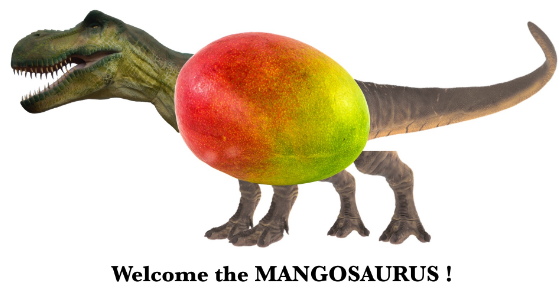

### Congratulations! 

You've finished the graded portion of this notebook and created a working language model! Awesome job. 

By now, you've: 

* Stored text data for processing using an RNN 
* Built a character-level text generation model
* Explored the vanishing/exploding gradient problem in RNNs
* Applied gradient clipping to avoid exploding gradients

You've also hopefully generated some dinosaur names that are cool enough to please you and also avoid the wrath of the dinosaurs. If you had fun with the assignment, be sure not to miss the ungraded portion, where you'll be able to generate poetry like the Bard Himself. Good luck and have fun!